In [1]:
import sys
import os
from pathlib import Path

import IPython
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

sys.path.append('../')
from src.dataset import get_forecast_df
from src.constants import (
    target_column_list,
    Columns,
    scores_file_name,
    submission_file_name
)
from src.forecast_util import get_result_base_dict, calc_scores, reset_random_seeds

if len(tf.config.list_physical_devices('GPU')) != 0:
    reset_random_seeds()
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'

plt.style.use('ggplot')

2023-01-09 08:58:22.673030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 08:58:23.737942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2023-01-09 08:58:23.737968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


## データの分割

* train:validation = 80:20

* valid_dfを最終予測に使用するために最後の60ステップ分だけを分離しておく

In [3]:
df, submit_df, ans_df = get_forecast_df('../data/')
df.drop(columns=Columns.date, inplace=True)
# train:validation = 80:20とする 
train_percent = 0.8
n = len(df)
# 次タイムステップの予測に用いるデータ数
n_forecast_to_use = 60
train_df, valid_df = df.iloc[:int(train_percent * n)], df.iloc[int(train_percent * n):]
valid_df, forecast_df = valid_df.iloc[:-n_forecast_to_use], valid_df[-n_forecast_to_use:]

## データセット作成用クラス作成

https://www.tensorflow.org/tutorials/structured_data/time_series を参考

イメージとしては、n_forecast_to_useで指定したステップ数から29ステップを予測するためのデータセットを作成する。

具体的な形状は、下記の通り。

* 入力: (バッチ数, ステップ数(30や60), 5(フレームワーク数))

* 出力: (バッチ数, ステップ数(29), 5(フレームワーク数))

ステップの例として、

入力の日付が 2022-01-01~2022-01-31 の場合

出力は、 2022-02-01~2022-02-28 となる。

In [4]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, train_df, valid_df, label_columns=target_column_list, batch_size=32):
        # データフレームをインスタンス変数として保持
        self.train_df = train_df
        self.valid_df = valid_df

        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # ウィンドパラメータの計算
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1
        )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, model=None, plot_col=Columns.tensorflow, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(plot_col)
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
            label_col_index = self.label_columns_indices.get(plot_col, None)
            if label_col_index is None:
                continue
            plt.scatter(self.label_indices, labels[n, :, label_col_index], label='Labels')
            if model is not None:
                predictions = model.predict(inputs, verbose=0)
                plt.scatter(
                    self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64
                )
            if n == 0:
                plt.legend()
        plt.xlabel('series')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size
        )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.valid_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

2023-01-09 08:26:11.563105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 08:26:11.563542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 08:26:11.563885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 08:26:11.564159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
Labels shape: (3, 1, 5)


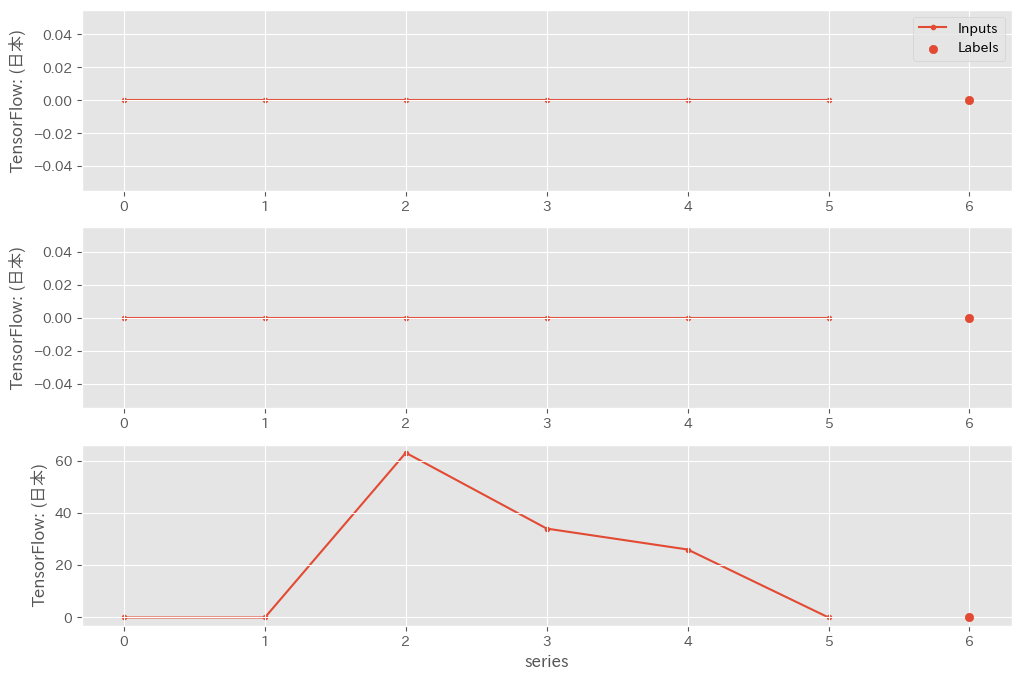

In [5]:
w1 = WindowGenerator(train_df=train_df, valid_df=valid_df, input_width=6, label_width=1, shift=1)
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])
example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')
w1.plot()

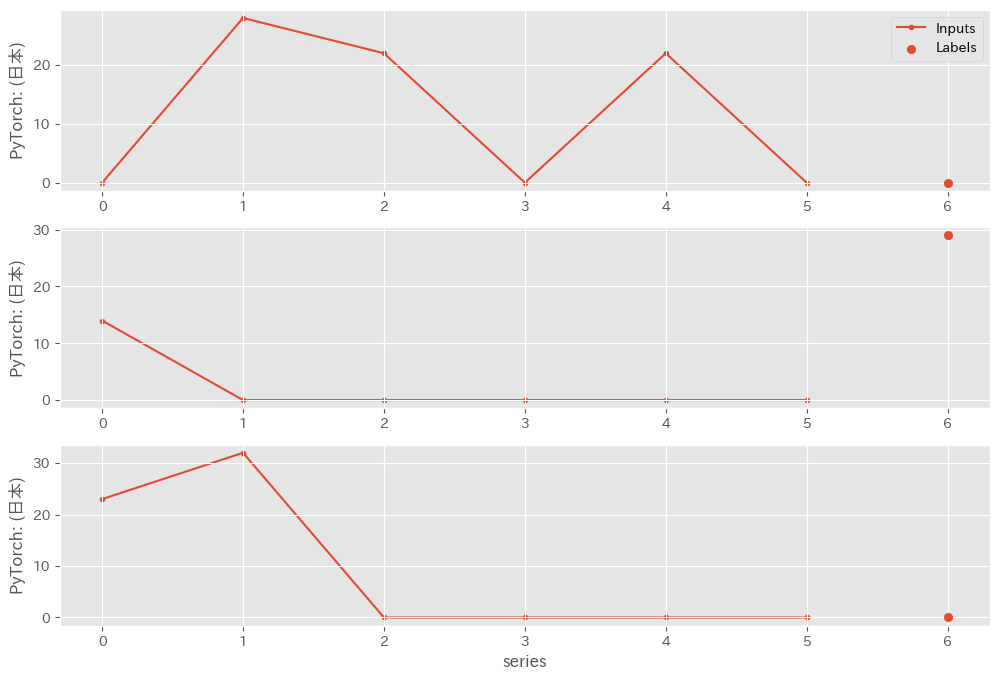

In [6]:
w1.plot(plot_col=Columns.pytorch)

In [7]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))

In [8]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 5)


Total window size: 89
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88]
Label column name(s): ['TensorFlow: (日本)', 'PyTorch: (日本)', 'Keras: (日本)', 'Caffe: (日本)', 'Deeplearning4j: (日本)']

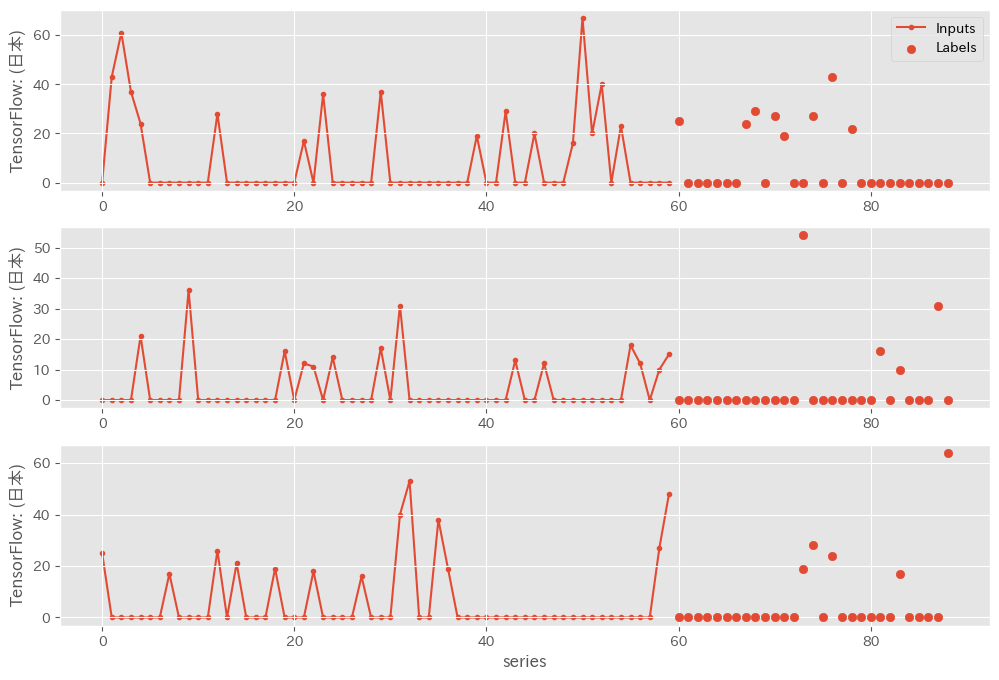

In [9]:
OUT_STEPS = len(submit_df)
INPUT_WIDTH = n_forecast_to_use
multi_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    valid_df=valid_df
)

multi_window.plot()
multi_window

## 学習

In [26]:
MAX_EPOCHS = 20

def compile_and_fit(model, window: WindowGenerator, patience=10, lr=1e-3, epochs=MAX_EPOCHS):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(lr),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )
    history = model.fit(
        window.train, epochs=epochs,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history


def create_lstm(out_steps=len(submit_df), num_features=5):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(out_steps * num_features, kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([out_steps, num_features])
    ])
    return model


def create_conv_model(conv_width=3, out_steps=len(submit_df), num_features=5):
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: x[:, -conv_width:, :]),
        tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(conv_width)),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(out_steps * num_features, kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([out_steps, num_features])
    ])
    return model


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

In [11]:
DST_BASE = Path('../result/dl_models/')
DST_BASE.mkdir(parents=True, exist_ok=True)

## CNN

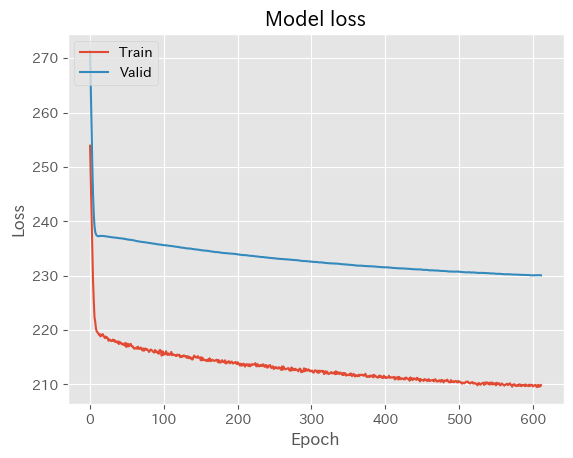

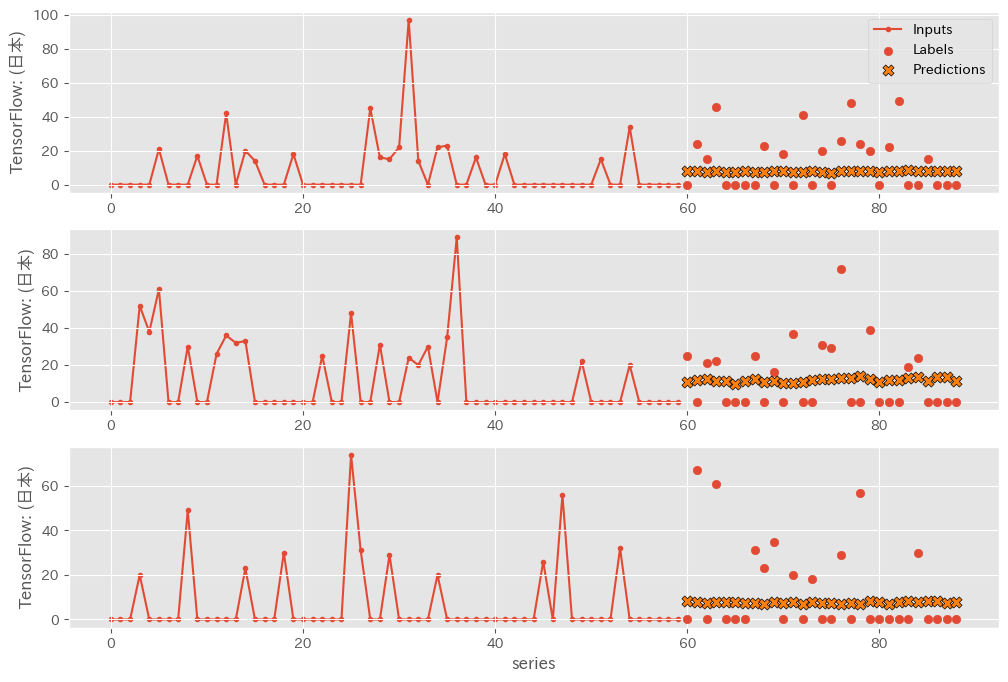

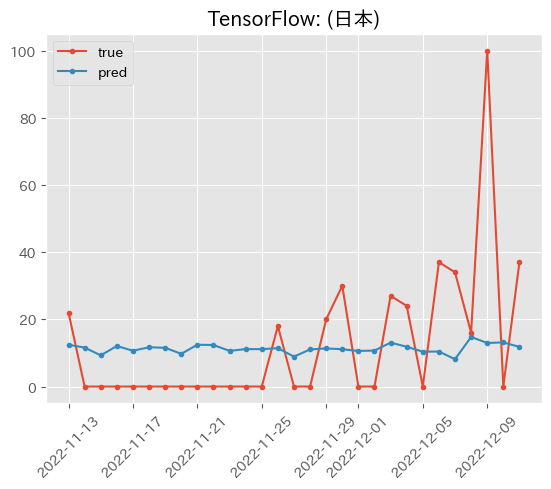

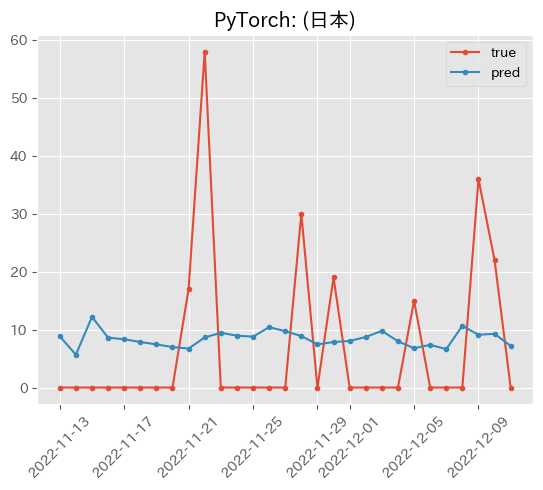

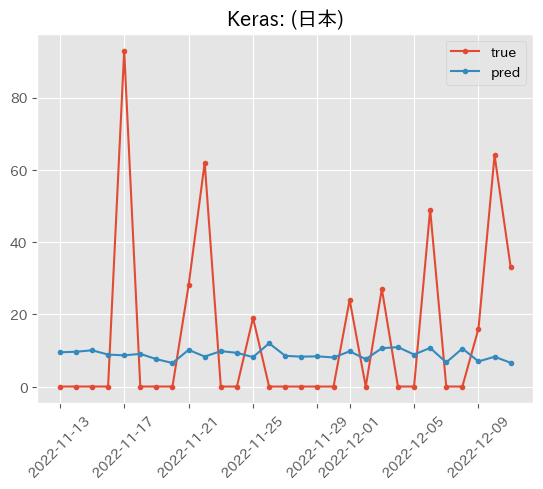

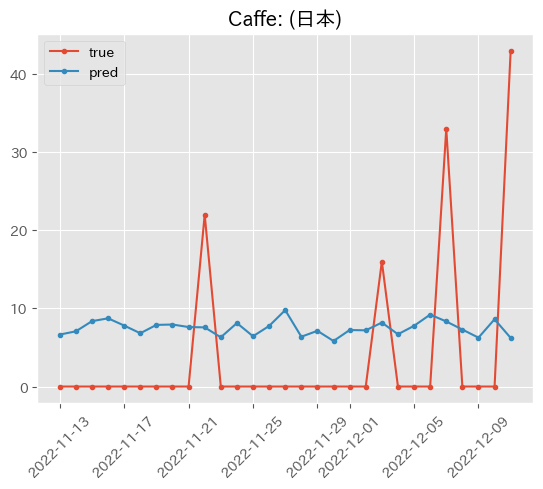

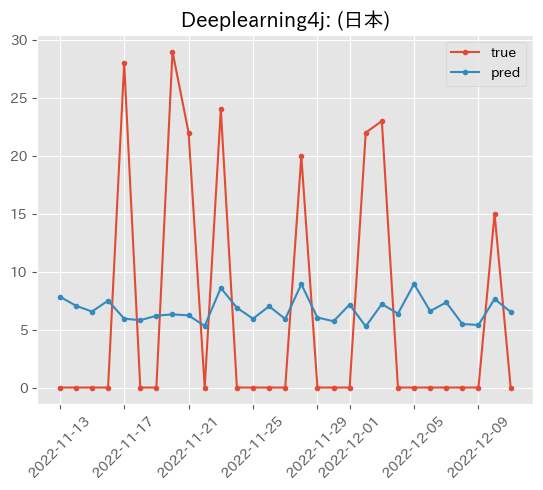

,framework,rmse,mape,mae
0,TensorFlow: (日本),20.940667,6.861623e+09,14.990608
1,PyTorch: (日本),14.022191,6.452447e+09,11.270372
2,Keras: (日本),24.790131,5.860138e+09,17.134818
3,Caffe: (日本),11.219149,6.443084e+09,9.329048
4,Deeplearning4j: (日本),10.358620,4.747314e+09,9.121969


In [28]:
reset_random_seeds()
OUT_STEPS = len(submit_df)
INPUT_WIDTH = n_forecast_to_use
multi_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    valid_df=valid_df
)
dst_dir = DST_BASE / 'cnn'
dst_dir.mkdir(parents=True, exist_ok=True)

conv_model = create_conv_model(conv_width=3)
history = compile_and_fit(model=conv_model, window=multi_window, epochs=1000, lr=1e-4)
IPython.display.clear_output()
plot_loss(history)
multi_window.plot(conv_model)
plt.show()
preds = conv_model.predict(forecast_df.values[None, :, :], verbose=0)[0]
# 結果のプロットとcsv保存
submit_df[target_column_list] = preds
result = get_result_base_dict()
for i, target_column in enumerate(target_column_list):
    plt.plot(ans_df[Columns.date], ans_df[target_column], label='true', marker='.')
    plt.plot(submit_df[Columns.date], submit_df[target_column], label='pred', marker='.')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(target_column)
    plt.savefig(dst_dir / f'{target_column}_forecast.png')
    plt.show()
    scores = calc_scores(ans_df[target_column].values, submit_df[target_column].values)
    result[i]['rmse'] = scores['rmse']
    result[i]['mape'] = scores['mape']
    result[i]['mae'] = scores['mae']
result = pd.DataFrame(result)
result.to_csv(dst_dir / scores_file_name, index=False)
submit_df.to_csv(dst_dir / submission_file_name, index=False)
result

## LSTM

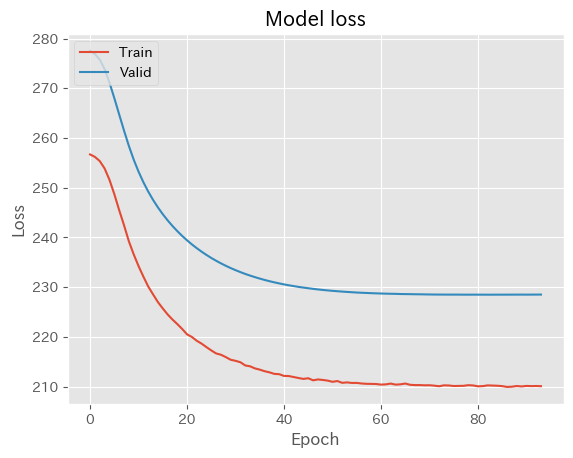

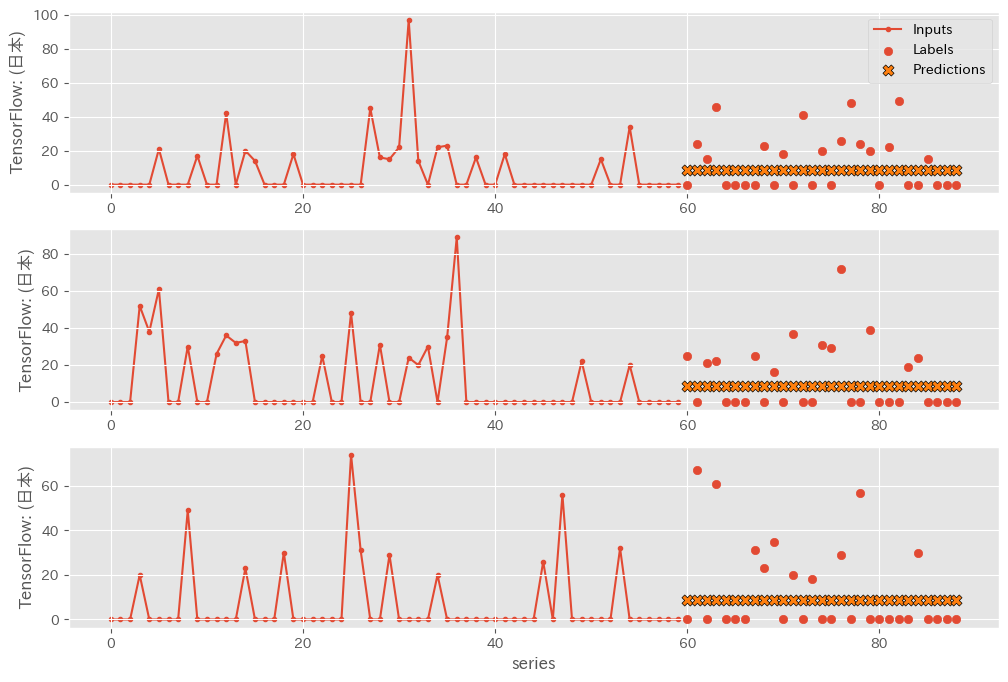

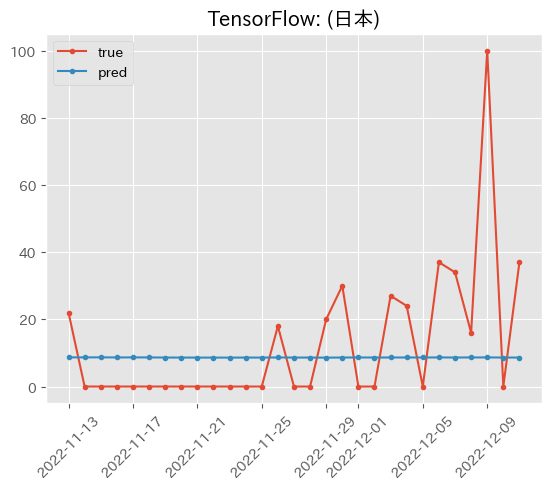

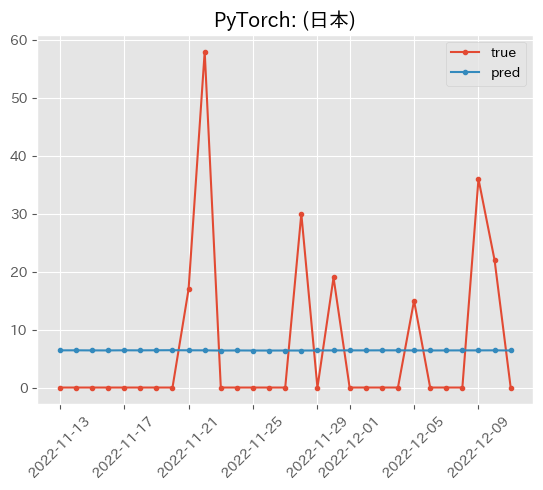

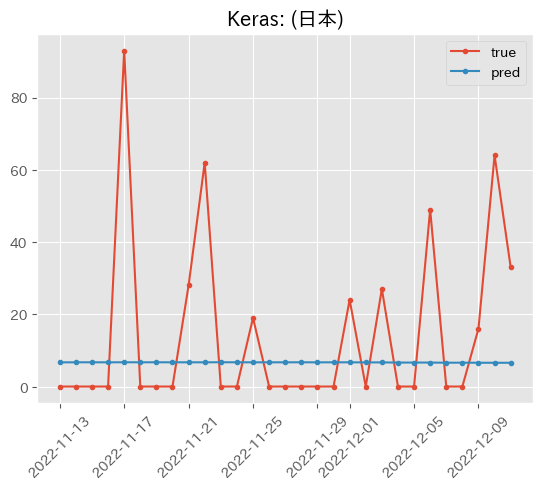

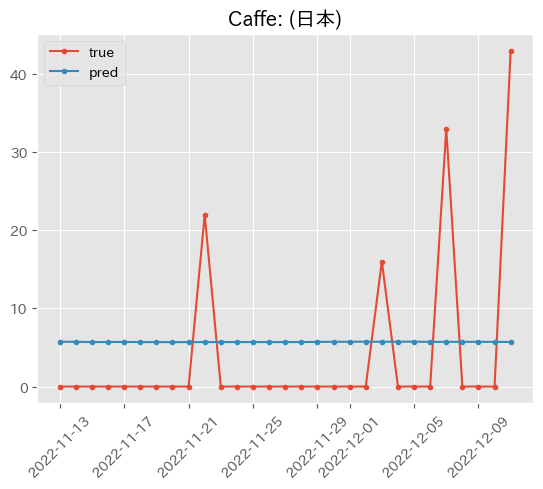

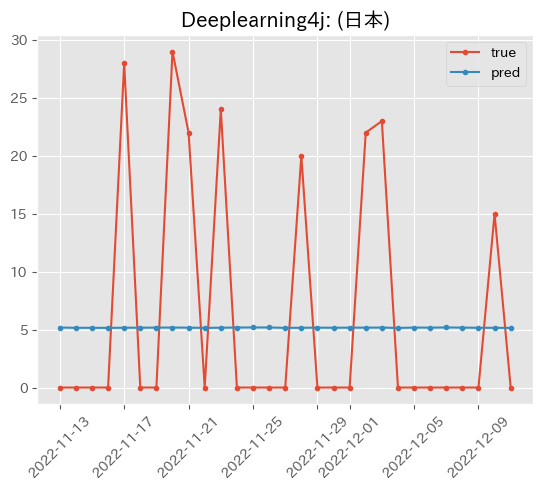

,framework,rmse,mape,mae
0,TensorFlow: (日本),21.507226,5.363245e+09,14.669287
1,PyTorch: (日本),13.876692,4.863071e+09,10.108444
2,Keras: (日本),25.289236,4.381371e+09,16.395339
3,Caffe: (日本),10.701878,4.921650e+09,8.064905
4,Deeplearning4j: (日本),10.513400,3.741071e+09,8.625778


In [13]:
reset_random_seeds()
OUT_STEPS = len(submit_df)
INPUT_WIDTH = n_forecast_to_use
multi_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    valid_df=valid_df
)
dst_dir = DST_BASE / 'lstm'
dst_dir.mkdir(parents=True, exist_ok=True)

lstm_model = create_lstm()
history = compile_and_fit(model=lstm_model, window=multi_window, epochs=1000, lr=1e-4)
IPython.display.clear_output()
plot_loss(history)
multi_window.plot(lstm_model)
plt.show()
preds = lstm_model.predict(forecast_df.values[None, :, :], verbose=0)[0]
# 結果のプロットとcsv保存
submit_df[target_column_list] = preds
result = get_result_base_dict()
for i, target_column in enumerate(target_column_list):
    plt.plot(ans_df[Columns.date], ans_df[target_column], label='true', marker='.')
    plt.plot(submit_df[Columns.date], submit_df[target_column], label='pred', marker='.')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(target_column)
    plt.savefig(dst_dir / f'{target_column}_forecast.png')
    plt.show()
    scores = calc_scores(ans_df[target_column].values, submit_df[target_column].values)
    result[i]['rmse'] = scores['rmse']
    result[i]['mape'] = scores['mape']
    result[i]['mae'] = scores['mae']
result = pd.DataFrame(result)
result.to_csv(dst_dir / scores_file_name, index=False)
submit_df.to_csv(dst_dir / submission_file_name, index=False)
result